In [1]:
from split_data import split
import numpy as np
import torch
from torchvision.datasets import ImageFolder
import torch.nn as nn
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchinfo import summary

from utils import *
# from convert_MLModel import convert_to_mlmodel

import matplotlib.pyplot as plt
import csv



In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using {device}")

Using cuda


In [ ]:
# torch.cuda.empty_cache()
import gc
model = None
gc.collect()
torch.cuda.empty_cache()

In [ ]:
source_path = "../Combined_data"
training_path = "../Combined_train_test/train"
testing_path = "../Combined_train_test/test"
train_test_ratio = 0.7
# split(source_path, training_path, testing_path, train_test_ratio) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


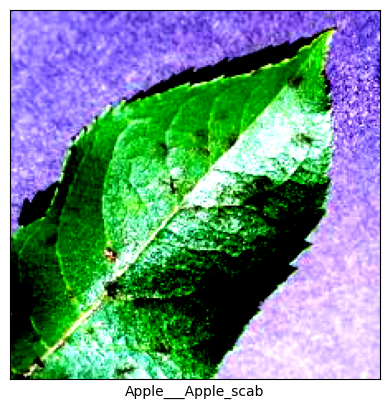

In [ ]:
# -------------[transform into suitable size for transfer learning]--------------------
transformation = preprocess()

train_dataset = ImageFolder(training_path, transform = transformation)

test_dataset = ImageFolder(testing_path,transform = transformation)

classes = train_dataset.classes

#display the first image in the dataset
display_img(*train_dataset[0], classes)

In [ ]:
batch_size = 64
learning_rate = 0.005
train_val_ratio = 0.8
num_epochs = 10
val_size = int(np.round(len(train_dataset) * (1-train_val_ratio)))
train_size = len(train_dataset) - val_size 

train_data, val_data = random_split(train_dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

train_dl = DataLoader(train_data, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 4, pin_memory = True)

test_dl = DataLoader(test_dataset, batch_size, num_workers = 4, pin_memory = True)
num_classes = len(classes)


Length of Train Data : 34430
Length of Validation Data : 8608


In [ ]:
# Defining all models
efficient_model = load_efficient_net().to(device)
efficient_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)


mobile_model = load_mobile_net().to(device)
mobile_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(in_features=1280, out_features=num_classes, bias=True)
).to(device)


resnet_model = load_resnet().to(device)
resnet_model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True).to(device)


# vgg_model = load_vgg().to(device)
# vgg_model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True).to(device)

loss_fn = nn.CrossEntropyLoss()


## Training EfficientNet-B0

In [ ]:
# efficientNet B0 model
optimizer = torch.optim.Adam(efficient_model.parameters(), lr=learning_rate)
efficient_results = train(model=efficient_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2158 | train_acc: 0.9395 | train_f1: 0.9395 | val_loss: 0.0711 | val_acc: 0.9791 | val_f1: 0.9792 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.0560 | train_acc: 0.9832 | train_f1: 0.9832 | val_loss: 0.0670 | val_acc: 0.9801 | val_f1: 0.9800 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.0531 | train_acc: 0.9838 | train_f1: 0.9838 | val_loss: 0.0433 | val_acc: 0.9875 | val_f1: 0.9875 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.0324 | train_acc: 0.9901 | train_f1: 0.9901 | val_loss: 0.0815 | val_acc: 0.9816 | val_f1: 0.9815 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0323 | train_acc: 0.9895 | train_f1: 0.9895 | val_loss: 0.0340 | val_acc: 0.9914 | val_f1: 0.9915 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0362 | train_acc: 0.9891 | tra

In [ ]:
path_name = "../Models/compared_csv/efficient_model("+str(batch_size)+", "+str(learning_rate)+").csv"
write_to_csv(path_name, efficient_results, num_epochs)

In [ ]:
efficient_report = test_run(efficient_model, test_dl, device, batch_size, classes)
print(efficient_report)

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      1.00      1.00       300
                            Apple___Black_rot       0.99      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      1.00      1.00       300
                              Apple___healthy       1.00      1.00      1.00       494
                    Background_without_leaves       0.99      0.99      0.99       343
                          Blueberry___healthy       1.00      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      0.99      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.98      0.87      0.92       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [ ]:
# Saving efficient model
torch.save(efficient_model, "../Models/compared_models/efficient_model("+str(batch_size)+", "+str(learning_rate)+").pt")

## Training MobileNet-V2

In [ ]:
# MobileNet V2 model
optimizer = torch.optim.Adam(mobile_model.parameters(), lr=learning_rate)
mobile_results = train(model=mobile_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)

# torch.save(mobile_model, "../Models/combined_mobile_model_1.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2338 | train_acc: 0.9368 | train_f1: 0.9368 | val_loss: 0.0719 | val_acc: 0.9772 | val_f1: 0.9773 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.0670 | train_acc: 0.9787 | train_f1: 0.9787 | val_loss: 0.0596 | val_acc: 0.9803 | val_f1: 0.9804 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.0476 | train_acc: 0.9850 | train_f1: 0.9850 | val_loss: 0.0475 | val_acc: 0.9848 | val_f1: 0.9849 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.0389 | train_acc: 0.9881 | train_f1: 0.9881 | val_loss: 0.0520 | val_acc: 0.9831 | val_f1: 0.9832 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0354 | train_acc: 0.9888 | train_f1: 0.9888 | val_loss: 0.0385 | val_acc: 0.9881 | val_f1: 0.9883 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0341 | train_acc: 0.9898 | tra

In [ ]:
mobile_report = test_run(mobile_model, test_dl, device, batch_size, classes)
print(mobile_report)

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.99      0.99       300
                            Apple___Black_rot       1.00      1.00      1.00       300
                     Apple___Cedar_apple_rust       1.00      0.99      0.99       300
                              Apple___healthy       1.00      0.99      0.99       494
                    Background_without_leaves       0.99      1.00      0.99       343
                          Blueberry___healthy       0.99      1.00      1.00       451
                      Cherry___Powdery_mildew       1.00      1.00      1.00       316
                             Cherry___healthy       1.00      0.99      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.99      0.72      0.83       300
                           Corn___Common_rust       1.00      1.00      1.00       358
                  Corn___Northern_Leaf_Bli

In [ ]:
path_name = "../Models/compared_csv/mobile_model("+str(batch_size)+", "+str(learning_rate)+").csv"
write_to_csv(path_name, mobile_results, num_epochs)

In [ ]:
torch.save(mobile_model, "../Models/compared_models/mobile_model("+str(batch_size)+", "+str(learning_rate)+").pt")

## Training ResNet-18

In [ ]:
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)
resnet_results = train(model=resnet_model,
                train_dataloader=train_dl,
                val_dataloader=val_dl,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=num_epochs,
                device=device)



  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2604 | train_acc: 0.9228 | train_f1: 0.9228 | val_loss: 0.2376 | val_acc: 0.9243 | val_f1: 0.9245 | 
--------------------------------------------------------------
Epoch: 2 | train_loss: 0.0990 | train_acc: 0.9679 | train_f1: 0.9679 | val_loss: 0.1363 | val_acc: 0.9582 | val_f1: 0.9584 | 
--------------------------------------------------------------
Epoch: 3 | train_loss: 0.0770 | train_acc: 0.9759 | train_f1: 0.9759 | val_loss: 0.0868 | val_acc: 0.9721 | val_f1: 0.9722 | 
--------------------------------------------------------------
Epoch: 4 | train_loss: 0.0602 | train_acc: 0.9794 | train_f1: 0.9794 | val_loss: 0.1246 | val_acc: 0.9616 | val_f1: 0.9617 | 
--------------------------------------------------------------
Epoch: 5 | train_loss: 0.0429 | train_acc: 0.9856 | train_f1: 0.9856 | val_loss: 0.2042 | val_acc: 0.9456 | val_f1: 0.9456 | 
--------------------------------------------------------------
Epoch: 6 | train_loss: 0.0482 | train_acc: 0.9840 | tra

In [ ]:
resnet_report = test_run(resnet_model, test_dl, device, batch_size, classes)
print(resnet_report)

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       1.00      0.93      0.96       300
                            Apple___Black_rot       0.99      1.00      1.00       300
                     Apple___Cedar_apple_rust       0.99      1.00      1.00       300
                              Apple___healthy       0.97      0.98      0.97       494
                    Background_without_leaves       0.98      0.99      0.99       343
                          Blueberry___healthy       0.97      1.00      0.98       451
                      Cherry___Powdery_mildew       0.98      0.99      0.98       316
                             Cherry___healthy       0.99      0.99      0.99       300
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.94      0.85      0.89       300
                           Corn___Common_rust       0.99      0.99      0.99       358
                  Corn___Northern_Leaf_Bli

In [ ]:
path_name = "../Models/compared_csv/resnet_model("+str(batch_size)+", "+str(learning_rate)+").csv"
write_to_csv(path_name, resnet_results, num_epochs)

In [ ]:
torch.save(resnet_model, "../Models/compared_models/resnet_model("+str(batch_size)+", "+str(learning_rate)+").pt")

## Training VGG

In [ ]:
# optimizer = torch.optim.Adam(vgg_model.parameters(), lr=learning_rate)
# vgg_results = train(model=vgg_model,
#                 train_dataloader=train_dl,
#                 val_dataloader=val_dl,
#                 optimizer=optimizer,
#                 loss_fn=loss_fn,
#                 epochs=num_epochs,
#                 device=device)

In [ ]:
# vgg_report = test_run(vgg_model, test_dl, device, batch_size, classes)
# print(vgg_report)

In [ ]:
# path_name = "../Models/compared_csv/vgg_modestr(batch_size)+", "+str(learning_rate)+").csv"
# write_to_csv(path_name, vgg_results, num_epochs)l("+

In [ ]:
# torch.save(vgg_model, "../Models/compared_models/vgg_model("+str(batch_size)+", "+str(learning_rate)+").pt")

### Finish